#### installs

In [1]:
!pip install git+https://github.com/openai/whisper.git 

  Cloning https://github.com/openai/whisper.git to /tmp/pip-req-build-ni5c06di
  Running command git clone --filter=blob:none --quiet https://github.com/openai/whisper.git /tmp/pip-req-build-ni5c06di

  Resolved https://github.com/openai/whisper.git to commit ba3f3cd54b0e5b8ce1ab3de13e32122d0d5f98ab
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
!sudo apt install ffmpeg

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libass9 libasyncns0 libavc1394-0 libavdevice58 libavfilter7 libavresample4
  libbs2b0 libcaca0 libcdio-cdda2 libcdio-paranoia2 libcdio18 libdc1394-22
  libfftw3-double3 libflac8 libflite1 libiec61883-0 libjack-jackd2-0
  liblilv-0-0 libmysofa1 libnorm1 libopenal-data libopenal1 libpgm-5.2-0
  libpostproc55 libpulse0 libraw1394-11 librubberband2 libsamplerate0
  libsdl2-2.0-0 libserd-0-0 libslang2 libsndfile1 libsndio7.0 libsodium23
  libsord-0-0 libsratom-0-0 libusb-1.0-0 libvidstab1.1 libxss1 libxv1 libzmq5
Suggested packages:
  ffmpeg-doc libfftw3-bin libfftw3-dev jackd2 libportaudio2 pulseaudio
  libraw1394-doc serdi sndiod sordi
The following NEW packages will be installed:
  ffmpeg libass9 libasyncns0 libavc1394-0 libavdevice58 libavfilter7
  libavresample4 libbs2b0 libcaca0 libcdio-cdda2 libcdio-paranoia2 libcdio18
  libdc1394-22 l

In [3]:
pip install setuptools-rust

Note: you may need to restart the kernel to use updated packages.


#### model

In [4]:
import whisper

model = whisper.load_model('base')
result = model.transcribe('input_audio.wav')
print(result['text'])

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/whisper/transcribe.py:126: UserWarning: FP16 is not supported on CPU; using FP32 instead
  warnings.warn("FP16 is not supported on CPU; using FP32 instead")


 Say I'm running a coin flip experiment, and I want to find out how likely each alchemy's heads or tails. So I public coin once, twice, a hundred times, and once I've repeated that experiment enough times, I see that about 50% of my flips or heads and 50% are tails. Now, that's not a particularly interesting result. You probably could have told me that's what would happen at the beginning. But what if the experiment I want to repeat is much bigger? Instead of physically performing the experiment, we can simulate it with code. For example, maybe I want to simulate a car crash to predict the risk of injury to the passengers. Or I want to simulate a forest fire to predict how far it'll spread. Or I want to simulate crop growth so I can predict yields and decide what to plant. These are all things that would be far too costly, too devastating, or take far too long to repeat in the real world. But if we build a computer simulation, we can repeat the experiment as many times as we want for f

In [11]:
import whisper
model = whisper.load_model('base')

# using ffmpeg to load the audio.
# returns dim audio array.
audio = whisper.load_audio('input_audio.wav')
print('original audio shape', audio.shape)

# checks for size of the audio and trim it or padded with zeros it if it's more that 30 sec length
# if you pass more than 30 sec audio you will lose the after 30 sec data.
# so it may be necessary to chunk your data to 30sec before passing it to the model.
audio = whisper.pad_or_trim(audio)
print('trimed (30sec) audio shape', audio.shape)

# takes usual amplitude vs time and create log mel spectogram.
# process:
# 1. uses SFTF (short time fourier transform) to get frequency for each time frame.
# 2. on each time frame all the frequencies are chopped in 80 bands. this bands are not equal
# it will be linear space upto around 1khz after that log spaced. this is done by using filter bank. the reason
# for this is that human auditory preception preceive this way of different fequency ranges. 
# this essentially mel-spect of the audio signal.
# 3. apply log to this mel spectogram. this is also done for how the human auditory preceive loudess, and also
# helps numerical stability.
# returns log-mel-spectogram of the audio signal. first axis will be frequency bands and second will be time axis.
mel = whisper.log_mel_spectrogram(audio).to(model.device)
print('mel spec shape', mel.shape)

original audio shape (2479200,)
trimed (30sec) audio shape (480000,)
mel spec shape torch.Size([80, 3000])


In [ ]:
# spectogram ploting technique
import matplotlib.pyplot as plt
import librosa 
import numpy as np


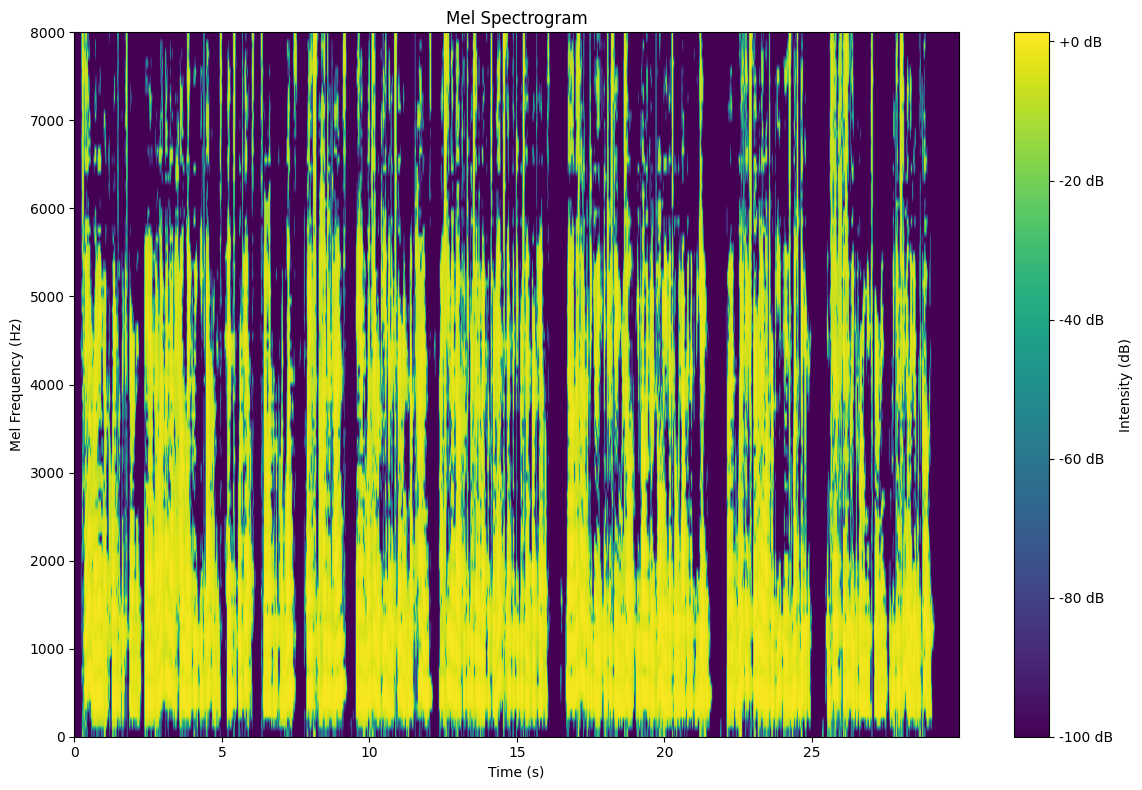

In [14]:
import matplotlib.pyplot as plt
import numpy as np

def plot_mel_spectrogram(mel_spec, sr=16000, hop_length=160):
    # Convert to dB scale
    mel_spec_db = 10 * np.log10(np.maximum(mel_spec, 1e-10))
    
    # Calculate time axis
    time = np.arange(0, mel_spec.shape[1]) * hop_length / sr
    
    # Calculate mel frequency axis (approximate)
    n_mels = mel_spec.shape[0]
    mel_freqs = np.linspace(0, sr/2, n_mels)
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 8))
    img = ax.imshow(mel_spec_db, aspect='auto', origin='lower', 
                    extent=[0, time[-1], mel_freqs[0], mel_freqs[-1]],
                    cmap='viridis')
    
    # Add colorbar
    cbar = fig.colorbar(img, ax=ax, format='%+2.0f dB')
    cbar.set_label('Intensity (dB)')
    
    # Set labels and title
    ax.set_title('Mel Spectrogram')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Mel Frequency (Hz)')
    
    plt.tight_layout()
    plt.show()

# Assuming your mel_spec is a torch tensor, convert it to numpy
mel_spec_np = mel.cpu().numpy()

# Call the function
plot_mel_spectrogram(mel_spec_np)

In [ ]:
# index select technique
import torch
x = torch.randn(100)
print(x[:2])
x.index_select(-1, torch.arange(2))

In [7]:
# padding technique
import torch
import torch.nn.functional as F
x = torch.randn(5)
pad_width = [(0, 0)] * x.ndim
# calc how to much needs to be padded
pad_width[-1] = (0, 10 - x.shape[-1])
# padding done from the last dim.
x = F.pad(x, [pad for sz in pad_width[::-1] for pad in sz ])
x

tensor([-0.8286, -0.3876,  0.2311, -0.3189, -0.1991,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000])